# Algorithms for path finding in graphs

This code accompanies the Algorithms lecture course for computer science at Cambridge University, taught by Damon Wischik.
* [Printed lecture notes](https://www.cl.cam.ac.uk/teaching/2021/Algorithms/notes2.pdf)
* [Videos on YouTube](https://www.youtube.com/playlist?list=PLknxdt7zG11PZjBJzNDpO-whv9x3c6-1H)

#### Contents

<ul><li><a href="#Depth-first-search">Depth-first search</a></li><li><a href="#Breadth-first-search">Breadth-first search</a></li><li><a href="#Dijkstra" s-algorithm'="">Dijkstra's algorithm</a></li><li><a href="#Bellman-Ford">Bellman-Ford</a></li><li><a href="#Dynamic-programming">Dynamic programming</a></li><li><a href="#Johnson" s-algorithm'="">Johnson's algorithm</a></li><li><a href="#Real-world-data:-the-OpenStreetMap-graph">Real-world data: the OpenStreetMap graph</a></li>
</ul>

In [1]:
# Make sure you have ucamcl_alg_utils.py in the current directory. It's in the
# repository with all the other notebooks. If you don't have your own copy of the
# repository, you can get the file from
# https://gitlab.developers.cam.ac.uk/djw1005/algorithms/-/blob/master/ucamcl_alg_utils.py

from ucamcl_alg_utils import DirectedGraph, UndirectedGraph, Stack, Queue, PriorityQueue

# Storing graphs

The "pseudocode" given in lecture notes is mostly actual working Python code. It is based on an Adjacency List representation of a graph, wrapped up as a nice Python object. The `ucamcl_alg_utils` package contains two classes, `DirectedGraph` and `UndirectedGraph`, both of which allow edges to be either labelled or unlabelled. Initialize them with a list of edges, as illustrated in the code snippets below. 

When you create a graph, you specify the edges by giving vertex ids; the graph will create a Vertex object for each vertex id. This allows you to attach attributes to each Vertex object, e.g. `v.distance` or `v.seen`. These two classes provide the following:
* `g.vertices` contains all the vertices, stored as `Vertex` objects
* `g.vertex['A']` gets the Vertex object for vertex id 'A'
* `g.edges` is a list \[(v,u),...\] or \[(v,u,lbl),...\], giving the Vertex at each end and (if provided) the edge label
* `v.neighbours` is a list \[u,...\] or \[(u,lbl),...\], giving the neighbouring Vertex and (if provided) the edge label

In [2]:
# Example use: Euler's graph for Koenigsberg
# stored as a directed graph (two edges, one in each direction, per bridge)

g = DirectedGraph([('A','B'),('A','B'),('A','D'),
                   ('B','A'),('B','A'),('B','C'),('B','C'),('B','D'),
                   ('C','B'),('C','B'),('C','D'),
                   ('D','A'),('D','B'),('D','C')])
for v in g.vertices:
    print(f'{v} has {len(v.neighbours)} neighbours')

C has 3 neighbours
A has 3 neighbours
B has 5 neighbours
D has 3 neighbours


In [3]:
# Example use: a directed graph with edge weights

g = DirectedGraph([('a','b',1), ('b','c',2), ('c','d',3), ('d','b',-6)])
for u,v,w in g.edges:
    print(f'The {u}→{v} edge has weight {w}')

The a→b edge has weight 1
The b→c edge has weight 2
The c→d edge has weight 3
The d→b edge has weight -6


# Depth-first search

In [4]:
edges = [('A','B'),('B','E'),('B','F'),('F','G'),('A','C'),('A','D'),('D','H')]
g = UndirectedGraph(edges)
g2 = UndirectedGraph(edges + [('C','D')])

In [5]:
# Bad attempt 1
def visit_tree(v):
    print("visiting", v)
    for w in v.neighbours:
        visit_tree(w)

# This next command will fail with "RecursionError: maximum recursion depth exceeded"
# visit_tree(g.vertex['B'])

In [6]:
# Bad attempt 2
def visit_tree(v, v_parent):
    print("visiting", v)
    for w in v.neighbours:
        if w != v_parent:
            visit_tree(w, v)

visit_tree(g.vertex['B'], None)

# This next command will fail with "RecursionError: maximum recursion depth exceeded"
# visit_tree(g2.vertex['D'], None)

visiting B
visiting E
visiting F
visiting G
visiting A
visiting C
visiting D
visiting H


In [7]:
def dfs_recurse(g, s):
    for v in g.vertices:
        v.visited = False
    visit(s)
    

# The plain algorithm for visit()
def visit(v):
    v.visited = True
    for w in v.neighbours:
        if not w.visited:
            visit(w)
    
# A fancy version of visit() that prints out its stack trace
def visit(v, prefix=''):
    v.visited = True
    print(f'{prefix}visit({v}): neighbours {", ".join([w.id for w in v.neighbours])}')
    prefix = prefix + '| '
    for w in v.neighbours:
        if not w.visited:
            visit(w, prefix)
        else:
            print(f"{prefix}don't visit {w}")
    print(f'{prefix}return from visit({v})')

In [8]:
dfs_recurse(g2, g2.vertex['D'])

visit(D): neighbours H, A, C
| visit(H): neighbours D
| | don't visit D
| | return from visit(H)
| visit(A): neighbours B, C, D
| | visit(B): neighbours E, F, A
| | | visit(E): neighbours B
| | | | don't visit B
| | | | return from visit(E)
| | | visit(F): neighbours G, B
| | | | visit(G): neighbours F
| | | | | don't visit F
| | | | | return from visit(G)
| | | | don't visit B
| | | | return from visit(F)
| | | don't visit A
| | | return from visit(B)
| | visit(C): neighbours D, A
| | | don't visit D
| | | don't visit A
| | | return from visit(C)
| | don't visit D
| | return from visit(A)
| don't visit C
| return from visit(D)


In [9]:
def dfs(g, s):
    for v in g.vertices:
        v.seen = False
    toexplore = Stack([s])
    s.seen = True
    
    while not toexplore.is_empty():
        print(f'toexplore={toexplore}', end=' ... ')
        v = toexplore.popright()
        print(f'visiting {v}')
        for w in v.neighbours:
            if not w.seen:
                print(f'  new neighbour {w}')
                toexplore.pushright(w)
                w.seen = True
            else:
                print(f'  seen neighbour {w}')

In [10]:
dfs(g2, g2.vertex['B'])

toexplore=[B] ... visiting B
  new neighbour E
  new neighbour F
  new neighbour A
toexplore=[E,F,A] ... visiting A
  seen neighbour B
  new neighbour C
  new neighbour D
toexplore=[E,F,C,D] ... visiting D
  new neighbour H
  seen neighbour A
  seen neighbour C
toexplore=[E,F,C,H] ... visiting H
  seen neighbour D
toexplore=[E,F,C] ... visiting C
  seen neighbour D
  seen neighbour A
toexplore=[E,F] ... visiting F
  new neighbour G
  seen neighbour B
toexplore=[E,G] ... visiting G
  seen neighbour F
toexplore=[E] ... visiting E
  seen neighbour B


# Breadth-first search

In [11]:
def bfs(g, s):
    for v in g.vertices:
        v.seen = False
    toexplore = Queue([s])
    s.seen = True
    
    while not toexplore.is_empty():
        print(f'toexplore {toexplore}', end='... ')
        v = toexplore.popleft()
        print(f'visiting {v}')
        for w in v.neighbours:
            if not w.seen:
                toexplore.pushright(w)
                w.seen = True
            else:
                print(f'  seen neighbour {w}')

In [12]:
def bfs_path(g, s, t):
    for v in g.vertices:
        v.seen = False
        v.come_from = None
    s.seen = True
    toexplore = Queue([s])
    
    # Traverse the graph, visiting everything reachable from s
    while not toexplore.is_empty():
        v = toexplore.popleft()
        for w in v.neighbours:
            if not w.seen:
                toexplore.pushright(w)
                w.seen = True
                w.come_from = v
                
    # Reconstruct the full path from s to t, working backwards
    if t.come_from is None:
        return None
    else:
        path = [t]
        while path[0].come_from != s:
            path.insert(0, path[0].come_from)  # i.e. prepend
        path.insert(0,s)
        return path

In [13]:
g = DirectedGraph([('a','b'),('a','d'),('b','e'),('b','d'),('b','c'),('c','a'),('d','a'),('d','c')])
bfs(g, g.vertex['a'])

toexplore [a]... visiting a
toexplore [b,d]... visiting b
  seen neighbour d
toexplore [d,e,c]... visiting d
  seen neighbour a
  seen neighbour c
toexplore [e,c]... visiting e
toexplore [c]... visiting c
  seen neighbour a


In [14]:
p = bfs_path(g, g.vertex['a'], g.vertex['e'])
' -> '.join(str(s) for s in p)

'a -> b -> e'

# Dijkstra's algorithm

In [15]:
def dijkstra(g, s):
    for v in g.vertices:
        v.distance = float('inf')
    s.distance = 0
    toexplore = PriorityQueue([s], sortkey = lambda v: v.distance)

    while not toexplore.is_empty():
        v = toexplore.popmin()
        # assert: v.distance is the true shortest distance from s to v
        # assert: v is never put back into toexplore
        for w,edgecost in v.neighbours:
            dist_w = v.distance + edgecost
            if dist_w < w.distance:
                w.distance = dist_w
                if w in toexplore:
                    toexplore.decreasekey(w)
                else:
                    toexplore.push(w)

In [16]:
# Disjktra is guaranteed to work when all edge costs are >= 0.

g = DirectedGraph([('s','t',2), ('s','v',3), ('t','u',2), ('u','v',1), ('v','t',4)])
dijkstra(g, g.vertex['s'])
for v in g.vertices:
    print(f"distance from s to {v} is {v.distance}")

distance from s to v is 3
distance from s to u is 4
distance from s to s is 0
distance from s to t is 2


In [17]:
# Let's see what it does on a graph with some edge costs < 0 ...

g = DirectedGraph([('s','t',2), ('s','v',3), ('t','u',3), ('u','v',1), ('v','t',-4)])
dijkstra(g, g.vertex['s'])
for v in g.vertices:
    print(f"distance from s to {v} is {v.distance}")

distance from s to v is 3
distance from s to u is 2
distance from s to s is 0
distance from s to t is -1


# Bellman-Ford

In [18]:
def bf(g, s):
    for v in g.vertices:
        v.minweight = float('inf')
    s.minweight = 0

    for _ in range(len(g.vertices) - 1):
        # relax all the edges
        for (u,v,c) in g.edges:
            v.minweight = min(u.minweight + c, v.minweight)
            # assert v.minweight >= true minimum weight from s to v

    for (u,v,c) in g.edges:
        if u.minweight + c < v.minweight:
            raise ValueError("Negative-weight cycle detected")

In [19]:
import math
g = DirectedGraph([('£','zl',-math.log(5.01)), ('£','$',-math.log(1.25)), ('zl','$',-math.log(0.27))])

bf(g, g.vertex['£'])

f"Best exchange rate £->$: £1 -> ${math.exp(- g.vertex['$'].minweight)}"

'Best exchange rate £->$: £1 -> $1.3527'

In [20]:
g= DirectedGraph([('a','b',1), ('b','c',2), ('c','d',3), ('d','b',-6)])
bf(g, g.vertex['a'])

ValueError: Negative-weight cycle detected

# Dynamic programming
### Version A: straightforward recursion

$$
\begin{aligned}
F_{d,t}(v) &= \min\Bigl( F_{d,t-1}(v)\,, \min_{w\,:\,v\to w} \Bigl\{ \operatorname{weight}(v\to w)+F_{d,t-1}(v)\Bigr\} \Bigr)\\
F_{d,0}(v) &= \begin{cases} 0 & \text{if }v=d\\ \infty & \text{otherwise.} \end{cases}
\end{aligned}
$$

In [21]:
g = DirectedGraph([('a','b',1), ('a','c',4), ('b','c',2), ('c','d',3), ('d','b',-4)])

In [22]:
dst = g.vertex['d']

# Cache computed values of F(v,t) in value[(v,t)], and computed actions in action[(v,t)].
# The function dp(v,t) looks for value[(v,t)], and if it doesn't exist in the cache
# then it computes it using the dynamic programming recursion.

value = {}
action = {}

def dp(v, t):
    if (v,t) in value:
        return value[(v,t)]
    if t == 0:
        val,act = (0 if v==dst else float('inf'), None)
    else:
        choices = [(dp(v,t-1), None)] + [(weight+dp(w,t-1), w) for w,weight in v.neighbours]
        val,act = min(choices, key = lambda x: x[0])
    value[(v,t)], action[(v,t)] = val,act
    return val

In [23]:
for t in [1,2]:
    for v in g.vertices:
        print(f'minweight({v} to {dst}) using paths with <= {t} edges: {dp(v,t)}')
    print()

minweight(b to d) using paths with <= 1 edges: inf
minweight(c to d) using paths with <= 1 edges: 3
minweight(d to d) using paths with <= 1 edges: 0
minweight(a to d) using paths with <= 1 edges: inf

minweight(b to d) using paths with <= 2 edges: 5
minweight(c to d) using paths with <= 2 edges: 3
minweight(d to d) using paths with <= 2 edges: 0
minweight(a to d) using paths with <= 2 edges: 7



In [24]:
# Compute the minweight path and cache it
# (Theorem says: if there are no -ve weight cycles, a time horizon of V-1 is sufficient.)

src = g.vertex['a']
V = len(g.vertices)
dp(src, V-1)

# Then retrieve it
path = [src]
for t in range(V-1,0,-1):
    v = path[-1]
    w = action[(v,t)]
    path.append(w)

f"Minweight path from {src} to {dst} is {'→'.join(str(v) for v in path)}, minweight is {value[(src,V-1)]}"

'Minweight path from a to d is a→b→c→d, minweight is 6'

### Version B: matrix algebra

In [25]:
import numpy as np

n = len(g.vertices)
W = np.full((n,n), np.inf)
np.fill_diagonal(W, 0)
vertex_ids = [v.id for v in g.vertices]
vi = {v_id:i for i,v_id in enumerate(sorted(vertex_ids))}
for u,v,c in g.edges:
    W[vi[u.id]][vi[v.id]] = c

def matmul(A,B):
    r,i = A.shape
    j,c = B.shape
    assert i==j, "number of A columns must equal number of B rows"
    x = np.empty((r,c), dtype=A.dtype)
    for i in range(r):
        for j in range(c):
            x[i,j] = np.min(A[i,:] + B[:,j])
    return x

M = W
for _ in range(int(np.ceil(np.log2(n-1)))): 
    M = matmul(M,M)

f"Minweight path from {src} to {dst} has weight {M[vi[src.id],vi[dst.id]]}"

'Minweight path from a to d has weight 6.0'

# Johnson's algorithm

In [26]:
# The original graph. Let the edge weights in the original graph be w(u->v).
g = DirectedGraph([('a','b',2), ('a','c',1), ('a','d',3), ('b','c',-2), ('c','e',-1), ('d','c',-2), ('d','e',4)])

In [27]:
# STEP 1. Build an augmented graph, with an extra node, and compute the d_v

s = '_s'
augmented = DirectedGraph([(v.id, w.id, c) for v,w,c in g.edges] + [(s, v.id, 0) for v in g.vertices])
bf(augmented, augmented.vertex[s])  # sets v.minweight for every vertex v

print(f"d_v[e] = {augmented.vertex['e'].minweight}")

d_v[e] = -3


In [28]:
# STEP 2. Define a helper graph, like the original 
# but with edge weight u->v given by d_u + w(u->v) - d_v
# In the helper graph, all edges should have weight >= 0.

helper = DirectedGraph([(v.id, w.id, augmented.vertex[v.id].minweight + c - augmented.vertex[w.id].minweight)
                         for v,w,c in g.edges])
assert min(c for v,w,c in helper.edges) >= 0, "Helper graph should have all edge weights >= 0"

weight_prime = {(u.id,v.id):w for u,v,w in helper.edges}
print(f"weight'(d→e) = {weight_prime[('d','e')]}")

weight'(d→e) = 7


In [29]:
# STEP 3. Run Disjktra, starting from every vertex in the helper graph, to get a matrix of distances.

import numpy as np
n = len(g.vertices)
dist = np.full((n,n), np.inf)
vertex_ids = [v.id for v in g.vertices]
vi = {vid:i for i,vid in enumerate(sorted(vertex_ids))}

for vid in vertex_ids:
    dijkstra(helper, helper.vertex[vid])
    for wid in vertex_ids:
        dist[vi[vid], vi[wid]] = helper.vertex[wid].distance

In [30]:
# STEP 4. Wrap up

d = np.zeros(n)
for vid in vertex_ids:
    d[vi[vid]] = augmented.vertex[vid].minweight
dist - d[:,np.newaxis] + d[np.newaxis,:]

array([[ 0.,  2.,  0.,  3., -1.],
       [inf,  0., -2., inf, -3.],
       [inf, inf,  0., inf, -1.],
       [inf, inf, -2.,  0., -3.],
       [inf, inf, inf, inf,  0.]])

# Real-world data: the OpenStreetMap graph

You can download OpenStreetMap data in XML format. For example, view [Cambridge](https://www.openstreetmap.org/export#map=12/52.1953/0.1348), and click on the link to download. Or you can use the XML that I downloaded.

In [31]:
# Execute a unix command to download a file (if it's not already downloaded), and show download progress
import os.path
if os.path.exists('data/osm_cam.xml'):
    print("file already downloaded")
else:
    !wget "https://www.cl.cam.ac.uk/teaching/2021/Algorithms/data/osm_cam.xml" -P data

file already downloaded


In [32]:
import collections
import lxml.etree
import numpy as np
import pandas

# A namedtuple is a record, i.e. an immutable object with variables and no methods.
# It prints out nicely too.
# It's a convenient way to store pure data.

Node = collections.namedtuple('Node', ('id','lat','lng'))
Way = collections.namedtuple('Way', ('id','nodes','highway','is_oneway','is_area'))

def make_node(el): 
    return Node(id=el.get('id'), lat=el.get('lat'), lng=el.get('lon'))
def get_tag_value(el, k):
    tag = el.find("tag[@k='{}']".format(k))
    return tag.get('v') if tag is not None else None
def make_way(el): 
    return Way(id=el.get('id'), 
               nodes=[nd.get('ref') for nd in el.findall('nd')], 
               highway=get_tag_value(el, 'highway'),
               is_oneway=get_tag_value(el, 'oneway'),
               is_area=get_tag_value(el, 'area'))

nodes,ways = [],[]
# Iterate through every element of the xml tree, leaf nodes first and working up
for _,el in lxml.etree.iterparse('data/osm_cam.xml'):
    if el.tag == 'node':
        nodes.append(make_node(el))
    elif el.tag == 'way':
        ways.append(make_way(el))
    elif el.tag in ['tag', 'nd']:
        continue
    # Save space by deleting the element-object after it's been processed.
    # Make sure we don't delete tag and nd, since we want the parent <way> to see them!
    el.clear()


coords = {n.id: (float(n.lng), float(n.lat)) for n in nodes}
edges = [(n1, n2, w) for w in ways for n1,n2 in zip(w.nodes[:-1],w.nodes[1:])]

osm = pandas.DataFrame({
    'n0': [n1 for n1,n2,w in edges],
    'n1': [n2 for n1,n2,w in edges],
    'x0': [coords[n1][0] for n1,n2,w in edges],
    'y0': [coords[n1][1] for n1,n2,w in edges],
    'x1': [coords[n2][0] for n1,n2,w in edges],
    'y1': [coords[n2][1] for n1,n2,w in edges],
    'highway': [w.highway for n1,n2,w in edges],
    'is_oneway': [w.is_oneway for n1,n2,w in edges],
    'is_area': [w.is_area for n1,n2,w in edges]})

osmv = pandas.DataFrame(((n.id, float(n.lng), float(n.lat)) for n in nodes), columns=['id','lng','lat'])

Here are some of the attributes that may be present in each &lt;way&gt;. Don't make assumptions about the possible values... OSM data is crowd-sourced and not always consistent.

In [33]:
ways[10]

Way(id='3217814', nodes=['14913683', '1483462366', '25285249', '3709007160', '25285243', '25285244', '3709007159', '25285245', '15695195', '6572094', '3698818604', '15695194', '1480279461', '575024329', '6572093'], highway='residential', is_oneway=None, is_area=None)

In [34]:
print('highways:', {w.highway for w in ways})
print('is_oneway:', {w.is_oneway for w in ways})
print('is_area:', {w.is_area for w in ways})

highways: {'footway', 'trunk_link', 'trunk', None, 'cycleway', 'primary_link', 'steps', 'primary', 'living_street', 'motorway_link', 'tertiary', 'crossing', 'unclassified', 'track', 'pedestrian', 'path', 'road', 'motorway', 'construction', 'bus_guideway', 'residential', 'secondary', 'service', 'bridleway'}
is_oneway: {'-1', 'yes', 'no', None}
is_area: {'yes', 'no', None}


#### Sample code for plotting

In [35]:
# Selecting edges and points in a circle around Mill Lane lecture rooms.
# To account for the scale of latitude and longitude, there needs to be a
# correction factor of cos(latitude) applied to north-south distances.

cy,cx = (52.201605, 0.117172)
c = np.cos(cy/360*2*np.pi)
osm['d'] = np.sqrt(np.maximum( ((osm['x0']-cx)*c)**2 + (osm['y0']-cy)**2, 
                               ((osm['x1']-cx)*c)**2 + (osm['y1']-cy)**2)) /360*40.075e6
osmv['d'] = np.sqrt( ((osmv['lng']-cx)*c)**2 + (osmv['lat']-cy)**2) /360*40.075e6

osm['meters'] = np.sqrt(((osm['x1']-osm['x0'])*c)**2 + (osm['y1']-osm['y0'])**2) /360*40.075e6

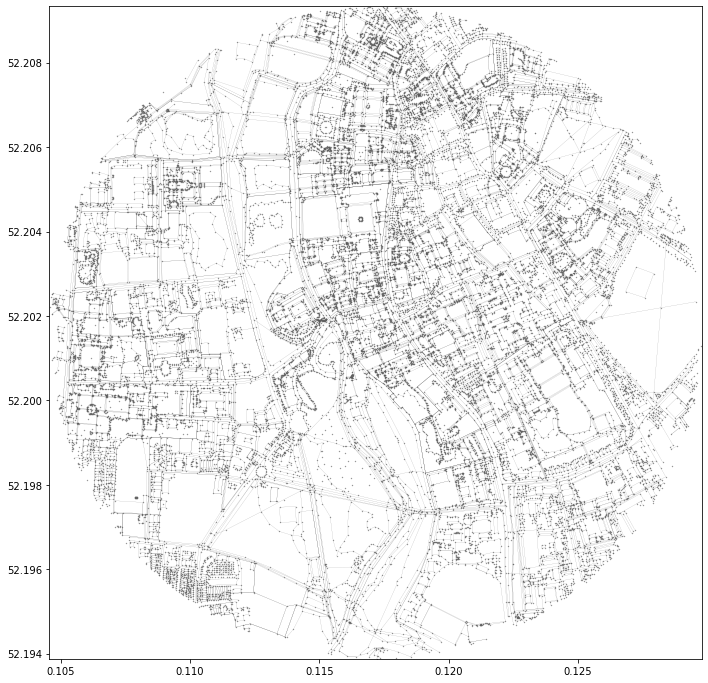

In [36]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

r = 860
segments = osm.loc[osm['d']<r][['x0','y0','x1','y1']].values.reshape((-1,2,2))
points = osmv.loc[osmv['d']<r][['lng','lat']].values

fig,ax = plt.subplots(figsize=(12,12))
lc = LineCollection(segments)
lc.set_linewidth(0.1)
lc.set_color('0.3')
ax.add_collection(lc)
ax.scatter(points[:,0], points[:,1], s=.1, color='0.4')
rd = r / 40.075e6 * 360
ax.set_xlim((cx-rd/c,cx+rd/c))
ax.set_ylim((cy-rd,cy+rd))
ax.set_aspect(1/c, 'box')
plt.show()